# CMC-15 - Lab 1

Importando pacotes:

In [16]:
from constants import OBSTACLES, WIDTH, HEIGHT
from math import sqrt, cos, sin, exp
import random
from typing import Tuple, Union, List, Callable
import heapq
import numpy as np
import matplotlib.pyplot as plt

## Questão 1

Inicializando o mapa:

In [2]:
table = np.ones((HEIGHT, WIDTH))

In [3]:
table[OBSTACLES] = -1.0

In [4]:
unaccesible_cells = table < 0.0

In [5]:
def is_index_valid(i: int, j: int):
    return 0 <= i < HEIGHT and 0 <= j < WIDTH

def get_successors(i: int, j: int):
    if i < 0 or j < 0:
        raise ValueError("Invalid indexes")
    successors = []
    for di in range(-1, 2):
        for dj in range(-1, 2):
            if (di != 0 and dj != 0) or (di == 0 and dj == 0):
                continue
            if is_index_valid(i + di, j + dj) and not unaccesible_cells[i + di, j + dj]:
                successors.append((i + di, j + dj))
    return successors

In [6]:
class Node:
    def __init__(self, i: int, j: int):
        """
        Creates a node of a graph used for planning paths.

        :param i: row of the node in the occupancy grid.
        :type i: int.
        :param j: column of the node in the occupancy grid.
        :type j: int.
        """
        self.i = i
        self.j = j
        self.f = np.inf
        self.g = np.inf
        self.closed = False
        self.parent: Union[Node, None] = None

    def get_position(self) -> Tuple[int, int]:
        """
        Obtains the position of the node as a tuple.

        :return: (i, j) where i is the row and the column of the node, respectively.
        :rtype: 2-dimensional tuple of int.
        """
        return self.i, self.j

    def set_position(self, i, j):
        """
        Sets the position of this node.

        :param i: row of the node in the occupancy grid.
        :type i: int.
        :param j: column of the node in the occupancy grid.
        :type j: int.
        """
        self.i = i
        self.j = j

    def distance_to(self, i: int, j: int) -> float:
        """
        Computes the distance from this node to the position (i, j).

        :param i: row of the target position.
        :type i: int.
        :param j: column of the target position.
        :type j: int.
        :return: distance from this node to (i, j).
        :rtype: float.
        """
        return sqrt((self.i - i) ** 2 + (self.j - j) ** 2)

    # for node < another_node
    def __lt__(self, another_node):
        return (self.i < another_node.i) or (self.j < another_node.j)

In [7]:
node_grid = np.empty(table.shape, dtype=Node)
for i in range(table.shape[0]):
    for j in range(table.shape[1]):
        node_grid[i, j] = Node(i, j)

In [8]:
def get_edge_cost(node: Node, successor: Node) -> float:
    return (table[node.get_position()] + table[successor.get_position()]) / 2.0

def reconstruct_path(end_node: Node):
    node = end_node
    reversed_path = []
    while node is not None:
        reversed_path.append(node.get_position())
        node = node.parent
    return reversed_path[::-1]

In [9]:
def a_star(start_position: Tuple[int, int], end_position: Tuple[int, int], node_grid: np.ndarray):
    node: Node = node_grid[start_position]
    node.g = 0
    node.f = node.g + node.distance_to(*end_position)
    pq: List[Tuple[float, Node]] = []
    heapq.heappush(pq, (node.f, node))

    while pq:
        (f, node) = heapq.heappop(pq)
        if not node.closed:
            node.closed = True
            
            if end_position == node.get_position():
                break
            
            for successor_t in get_successors(node.i, node.j):
                successor: Node = node_grid[successor_t]
                if successor.f > node.g + get_edge_cost(node, successor) + successor.distance_to(*end_position):
                    successor.g = node.g + get_edge_cost(node, successor)
                    successor.f = successor.g + successor.distance_to(*end_position)
                    successor.parent = node
                    heapq.heappush(pq, (successor.f, successor))

    end_node: Node = node_grid[end_position]

    return reconstruct_path(end_node), end_node.g

In [10]:
path, g = a_star((0, 0), (20, 23), node_grid)

In [11]:
for tup in path:
    table[tup] += 1

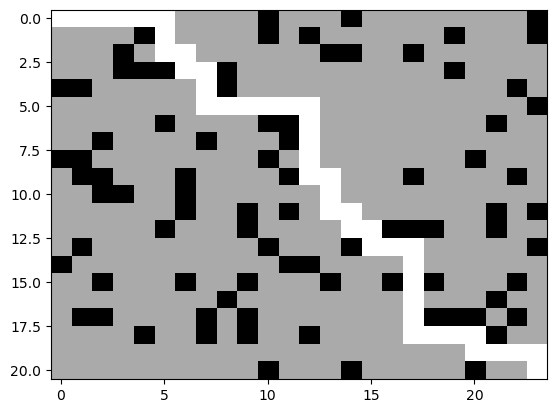

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(table, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')

## Questão 2

## Questão 3

In [88]:
cost_function = lambda x, y: -4 * np.exp(-x**2 - y**2 + 2*x + 2*y - 2) - np.exp(-(x-3)**2 - (y-3)**2) - np.exp(-(x+3)**2 - (y-3)**2) - np.exp(-(x-3)**2 - (y+3)**2) - np.exp(-(x+3)**2 - (y+3)**2)

In [90]:
def simulated_annealing(cost_function: Callable, temperature_schedule: Callable, random_neighbour: Callable, theta0: np.ndarray, epsilon: float, max_iter: int):
    theta = theta0
    history = [theta0]

    for i in range(max_iter):
        temp = temperature_schedule(i)
        if temp < 0.:
            return theta, history
        neighbour = random_neighbour(theta)
        delta_e = cost_function(*theta) - cost_function(*neighbour)
        if delta_e >= 0.:
            theta = neighbour
            history.append(theta)
        else:
            r = random.uniform(0, 1)
            if r < exp(delta_e/temp):
                theta = neighbour
                history.append(theta)
        if cost_function(*theta) > -epsilon:
            break

    return theta, history

In [18]:
# hyperparams and helper functions

DELTA = 2.0e-3
BETA = 0.9
TEMPERATURE0 = 1.0

temperature = lambda i: TEMPERATURE0/(1 + BETA*(i**2))

def random_neighbour(theta):
    angle = random.uniform(-np.pi, np.pi)
    neighbour = theta + np.array([DELTA * cos(angle), DELTA * sin(angle)])
    return neighbour

In [95]:
theta, history = simulated_annealing(cost_function, temperature, random_neighbour, np.array([0., 0.]), 1.0e-10, 5000)

In [96]:
len(history)

1126

In [97]:
cost_function(*theta)

-4.000334328580423

In [94]:
theta

array([1.00030594, 1.00045801])